To Do's: 

- zwei code blocks, die mit listen arbeiten in arrays umwandeln -> performanter

Books: 

https://www.taylorfrancis.com/books/edit/10.1201/9780367631888/recommender-systems-pavan-kumar-vairachilai-sirisha-potluri-sachi-nandan-mohanty

https://beluga.sub.uni-hamburg.de/vufind/Record/1656091313?rank=1

In [1]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from surprise import Reader, Dataset
from surprise import KNNBasic, SVD, CoClustering, SlopeOne
from surprise.model_selection import KFold, RepeatedKFold, cross_validate, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import time

In [2]:
df = pd.read_csv("person-skills_2022-06-27.csv",sep=";")
df 

,person,skill,category
0,12,Windows NT/2000/XP,Betriebssystem
1,12,MAC OS X,Betriebssystem
2,12,Windows 7,Betriebssystem
3,12,Windows 8,Betriebssystem
4,12,iOS,Betriebssystem
...,...,...,...
24581,1488,Deutsch,Sprachen
24582,1488,Spring-JPA,Java Frameworks
24583,1488,Maven,"CI/CD, Build- und Versionskontrollsysteme"
24584,1488,Subversion,"CI/CD, Build- und Versionskontrollsysteme"


In [3]:
data = df

In [4]:
# So later functions work, it makes sense to rename persons from 1 to maxno. 
# Create dictionary which matches the employee
persons = data["person"].unique()
#np.arange(1,len(data["person"].unique())+1)
skills = sorted(data["skill"].unique())

In [5]:
skills_per_person = []
for person in data["person"].unique(): 
    skillset = []
    for skill in skills:
        if skill in data[data["person"] == person]["skill"].unique():
            skillset.append(1)
        else:
            skillset.append(0)
    skills_per_person.append(skillset)


In [6]:
matrix = pd.DataFrame(index=persons,columns=skills,data=skills_per_person)

# Recommender 

## Nearest Neighbors Approach

In [7]:
data = df#[~df["category"].isin(["Betriebssystem", "Dienste", "Einsatzfelder / Erfahrungen / Schwerpunkte", "Rolle (intern)"])]

In [8]:
data.head(20)

,person,skill,category
0,12,Windows NT/2000/XP,Betriebssystem
1,12,MAC OS X,Betriebssystem
2,12,Windows 7,Betriebssystem
3,12,Windows 8,Betriebssystem
4,12,iOS,Betriebssystem
5,12,Android,Betriebssystem
6,12,PostgreSQL,Datenbank
7,12,MySQL,Datenbank
8,12,LDAP,Datenbank
9,12,Microsoft Access,Datenbank


In [9]:
employee_dict = {}
for n in range(1,data["person"].nunique()+1):
    employee_dict[n] = data["person"].unique()[n-1]

In [10]:
# So later functions work, it makes sense to rename persons from 1 to maxno. 
# Create dictionary which matches the employee
persons = data["person"].unique()
#np.arange(1,len(data["person"].unique())+1)
skills = sorted(data["skill"].unique())

In [11]:
skills_per_person = []
for person in data["person"].unique(): 
    skillset = []
    for skill in skills:
        if skill in data[data["person"] == person]["skill"].unique():
            skillset.append(1)
        else:
            skillset.append(0)
    skills_per_person.append(skillset)


In [12]:
matrix = pd.DataFrame(index=persons,columns=skills,data=skills_per_person)

In [13]:
matrix

,.NET Compact Framework,.NET Core,.NET Framework,3D-Modellierung,ABAP,ADO.NET,AIX,ARIS,ARIS ITArchitect,AS400,...,ramda.js,ranorex,samba,script.aculo.us,varnish,visual paradigm,vnc,vs code,xHTML,xtCommerce
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1474,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1475,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1479,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Employee-employee approach

Similarity between employees: due to dichotomous nature of data, Jaccard similarity is used for computing the similarity between employees. 

In [14]:
def jaccard_binary(x,y):
    """A function for finding the similarity between two binary vectors"""
    intersection = np.logical_and(x, y)
    union = np.logical_or(x, y)
    similarity = intersection.sum() / float(union.sum())
    return similarity

In [15]:
def compute_jaccard_sim(data,employee):
    sim = pd.DataFrame(index=[employee])
    employee_data = data.loc[employee]
    sim_data = data.drop(employee,axis=0)
    for emp in sim_data.index:
        new_sim = pd.DataFrame(index=[employee],columns=[emp],data=jaccard_binary(employee_data,sim_data.loc[emp]))
        sim = pd.concat([sim,new_sim],axis=1)
    return sim       

In [16]:
def compute_n_nearest_neighbors(data,employee,n):
    neighbors = pd.DataFrame(index=[employee])
    similarities = compute_jaccard_sim(data,employee)
    for i in range(0,n):
        nearest_neighbor = similarities[similarities.idxmax(axis=1)]
        neighbors = pd.concat([neighbors,nearest_neighbor],axis=1)
        similarities.drop(nearest_neighbor,axis=1,inplace=True)
    return neighbors.columns.to_list()

In [17]:
def predict_skills_for_employee(data,employee,n_neighbors):
    neighbors = compute_n_nearest_neighbors(data,employee,n_neighbors)
    values_of_employee = data.loc[employee].to_numpy()
    neighbors_matrix = data.loc[neighbors].to_numpy()
    predicted_values = np.array([])
    for i in range(0,len(values_of_employee)):
        if values_of_employee[i] == 0: 
            predicted_values = np.append(predicted_values,
                                            # weighted averahe might be more accurate
                                            np.mean(neighbors_matrix[:,i]))
        else: 
            predicted_values = np.append(predicted_values,values_of_employee[i])
    return predicted_values

In [18]:
def predict_skills_for_matrix(data,n_neighbors): 
    # create emppy array of length according to columns (in order for later vstack to work)
    return_data = np.zeros(len(data.columns))
    for i in data.index: 
        single_predicition = predict_skills_for_employee(data,i,n_neighbors)
        return_data = np.vstack([return_data,single_predicition])
    # delete first entry (zeros) from return data
    return_data = return_data[1:len(return_data)]
    return pd.DataFrame(index=data.index,columns=data.columns,data=return_data)

In [19]:
#predict_skills_for_matrix(matrix,10)

## Matrix Facorization

Create matrix with values between 1 and 5 for recommender trials

Values between 1 and 5 should not be arbitrary. As weight for their score, the frequency of the underlying category for each skill will be taken into account. For instance, if employee 12 has four skills in the category programming language and one skill in data banks, each programming skill will be evaluated with a respectivley high score. 

In [20]:
skills_to_category = pd.read_csv("mitarbeiterportal-skills_2022-06-21.csv",sep=";",header=None)
category_dict = dict(zip(skills_to_category[0],skills_to_category[1]))

In [21]:
def scaler_1_5(x,old_max,old_min):
    OldRange = (old_max - old_min)  
    if (OldRange == 0):
        return 1
    else:
        NewRange = (5 - 1)  
        return round((((x - 1) * NewRange) / OldRange) + 1)

In [22]:
# create dataframe for each employee and their category count
categories = data["category"].unique()
category_per_employee = pd.DataFrame(index=categories)
for p in persons:
    p_skills = data[data["person"] == p]
    # count categories for each employee
    category_count = p_skills["category"].value_counts()
    category_count = category_count.apply(lambda x:scaler_1_5(x,category_count.max(),category_count.min()))
    skill_values = np.array([])
    # add count for each category to an array and 0 if category wasn't found (and therefore is not part of resptive employee's skillset)
    for cat in categories:
        try:
            skill_values = np.append(skill_values,category_count[cat])
        except KeyError:
            skill_values = np.append(skill_values,0)
    # add employee data to dataframe
    p_skills_df = pd.DataFrame(index=categories,columns=[p],data=skill_values)
    category_per_employee = pd.concat([category_per_employee,p_skills_df],axis=1)

In [23]:
skills_per_person_weighted = []
for p in persons: 
    skillset = []
    for skill in skills:
        if skill in data[data["person"] == p]["skill"].unique():
            skillset.append(category_per_employee[p][category_dict[skill]])
        else:
            skillset.append(0)    
    skills_per_person_weighted.append(skillset)

In [24]:
matrix_mod = pd.DataFrame(index=persons,columns=skills,data=skills_per_person_weighted)
matrix_mod

,.NET Compact Framework,.NET Core,.NET Framework,3D-Modellierung,ABAP,ADO.NET,AIX,ARIS,ARIS ITArchitect,AS400,...,ramda.js,ranorex,samba,script.aculo.us,varnish,visual paradigm,vnc,vs code,xHTML,xtCommerce
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1479,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system

In [25]:
from surprise import Reader, Dataset, SVD, accuracy
#from surprise.model_selection import cross_validate, train_test_split

In [26]:
matrix_mod[matrix_mod == 0].count().sum()/matrix_mod[matrix_mod != 0].count().sum()

11.287002937890511

11 times more 0 values than values with a rating.

In [27]:
skill_alphabetically = sorted(skills_to_category[0].to_list())
skills_dict = {x:skill_alphabetically[x] for x in range(0,len(skill_alphabetically))}

In [28]:
employee_dict_inv = {v: k for k, v in employee_dict.items()}

Create data structure suitable for surprise library:

In [29]:
df_np = df.to_numpy()

for i in range(0,len(df_np)):
    df_np[i][2] = matrix_mod.loc[df_np[i][0]][df_np[i][1]]

df_rated = pd.DataFrame(df_np)
df_rated.columns = ["Employee","Skill","Rating"]
df_rated    

,Employee,Skill,Rating
0,12,Windows NT/2000/XP,4.0
1,12,MAC OS X,4.0
2,12,Windows 7,4.0
3,12,Windows 8,4.0
4,12,iOS,4.0
...,...,...,...
24581,1488,Deutsch,1.0
24582,1488,Spring-JPA,5.0
24583,1488,Maven,3.0
24584,1488,Subversion,3.0


In [30]:
df_category_rating = pd.concat([df_rated,df["category"]],axis=1)

In [31]:
reader = Reader()
svd_data = Dataset.load_from_df(df_rated,reader)

RMSE >= 0.75 -> bueno <br>
MAE? no sé

In [32]:
svd = SVD()
cv = cross_validate(svd, svd_data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8183  0.8298  0.8105  0.8252  0.8302  0.8228  0.0075  
MAE (testset)     0.6350  0.6379  0.6150  0.6351  0.6358  0.6318  0.0085  
Fit time          0.09    0.11    0.11    0.09    0.09    0.10    0.01    
Test time         0.02    0.02    0.01    0.01    0.01    0.02    0.00    


In [33]:
trainset, testset = train_test_split(svd_data, test_size=0.25)
svd.fit(trainset)

In [34]:
predictions = svd.test(testset)

In [35]:
def get_skills_of_employee(emp_id):
    df_category_rating[df_category_rating["Employee"] == emp_id]["category"].value_counts().plot(kind="bar",ylabel="Count",title="Skill Category Portfolio Employee "+str(emp_id))
    return df_category_rating[df_category_rating["Employee"] == emp_id]

Manual prediciton testing: input skill of employee that they already know and check the prediciton vs. the actual value

In [36]:
employee_id = str(1479)
skill_id = ".NET Core" 

# get a prediction for specific users and items.
pred = svd.predict(employee_id, skill_id, r_ui=5, verbose=True)

user: 1479       item: .NET Core  r_ui = 5.00   est = 3.25   {'was_impossible': False}


,Employee,Skill,Rating,category
0,12,Windows NT/2000/XP,4.0,Betriebssystem
1,12,MAC OS X,4.0,Betriebssystem
2,12,Windows 7,4.0,Betriebssystem
3,12,Windows 8,4.0,Betriebssystem
4,12,iOS,4.0,Betriebssystem
...,...,...,...,...
73,12,SQL,3.0,Datenbank
74,12,SCRUM,3.0,Projektmanagement / Vorgehensmodelle
75,12,JIRA,1.0,Issue Management
76,12,Maven,4.0,"CI/CD, Build- und Versionskontrollsysteme"


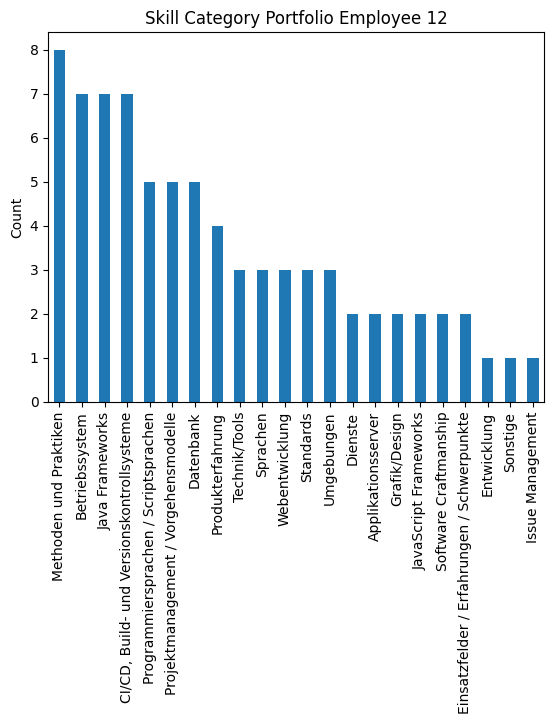

In [37]:
get_skills_of_employee(12)

HOW TO EVALUATE RECOMMENATIONS? <BR>
HOW TO IMPLEMENT NEAT WAY OF GETTING RECOMMENDATIONS/RECOMMEND EMPLOYEES FOR CERTAIN SKILLS

In [38]:
# Create item-based representation of DataFrame (cause we might need it later?)
df_item_based = df_category_rating.sort_values(by="Skill")[["Skill","Employee","Rating","category"]]
item_based_data = df_item_based[["Skill","Employee","Rating"]].to_numpy()

## Comparing Different Recommender Systems

First, lets pick some algorithms to include into our ensemble. We'll choose four.
-  Collaborative Filtering
-  Matrix Factorization
-  collaborative filtering with co-clustering
-  Collaborative Filtering based on the popular Slope One Algorithm

https://www.kaggle.com/code/robottums/hybrid-recommender-systems-with-surprise/notebook

In [39]:
from surprise import Reader, Dataset
from surprise import KNNBasic, KNNWithMeans, SVD, CoClustering, SlopeOne, SVDpp, NMF, BaselineOnly
from surprise.model_selection import KFold, RepeatedKFold, cross_validate, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import time

Idea: Try to recreate cross validation set up from above link and compare different recommendation techiques. 
Ablauf: run cros val and protocol KPI's (RMSE etc.), then build comprehensive recommendation function for best performing recommender.

In [40]:
reader = Reader(rating_scale=(1,5))
svd_data = Dataset.load_from_df(df_rated,reader)

In [41]:
NUM_TRIALS = 5
NUM_OUTER_SPLITS = 5

In [42]:
def nested_cv(algo,data):
    
    start = time.time()
    rmse = np.zeros((NUM_TRIALS, NUM_TRIALS))
    mae = np.zeros((NUM_TRIALS, NUM_TRIALS))
    fit_times = np.zeros((NUM_TRIALS, NUM_TRIALS))
    test_times = np.zeros((NUM_TRIALS, NUM_TRIALS))

    for i in range(NUM_TRIALS):
        outer_cv = KFold(n_splits=NUM_OUTER_SPLITS,shuffle=True,random_state=36)
        cv_results = cross_validate(algo=algo,data=data,measures=["rmse","mae"],cv=outer_cv,n_jobs=8)
        rmse[i] = cv_results["test_rmse"]
        mae[i] = cv_results["test_mae"]
        fit_times[i] = cv_results["fit_time"]
        test_times[i] = cv_results["test_time"]

    return rmse,mae, fit_times, test_times

In [43]:
def add_result(results, name, accs, baccs, fit_times, test_times):
    '''
    Function adding the results returned by nested_cv to a dataframe. 
    Results will be aggregated for better comparison. 
    Parameters: 
    results = DataFrame which the results should be added to
    name = string describing the estimator which values are to be added
    accs = accuracy values of estimator
    baccs = balanced accuracy values of estimator 
    fit_times = fitting times of estimator
    test_times = testing times of estimator
    Output:
    results DataFrame containing an additional row
    '''
    row = pd.DataFrame({
        "name":name,
        "rmse_mean":accs.mean(), 
        "rmse_std":accs.std(), 
        "rmse_min":accs.min(), 
        "rmse_max":accs.max(), 
        "mae_mean":baccs.mean(), 
        "mae_std":baccs.std(), 
        "mae_min":baccs.min(), 
        "mae_max":baccs.max(), 
        "fit_time":fit_times.mean(),
        "test_time":test_times.mean()
        },index=[0])
    return pd.concat([results,row],ignore_index=True)

In [44]:
results = pd.DataFrame()

In [45]:
algo_list = [(BaselineOnly(),"Baseline"),
                (KNNBasic(),"k-NN"),
                (KNNWithMeans(),"Centered k-NN"),
                (SVD(),"SVD"),
                (SVDpp(),"SVD++"),
                (CoClustering(),"CoClustering"),
                (SlopeOne(),"SlopeOne"),
                (NMF(),"NMF")
            ]

In [46]:
for algo in algo_list:
    rmse, mae, fit_times, test_times = nested_cv(algo[0],svd_data)
    results = add_result(results,algo[1],rmse,mae,fit_times,test_times)

In [47]:
results

,name,rmse_mean,rmse_std,rmse_min,rmse_max,mae_mean,mae_std,mae_min,mae_max,fit_time,test_time
0,Baseline,0.975745,0.005869,0.970008,0.983462,0.783142,0.007228,0.775106,0.793709,0.006235,0.008766
1,k-NN,0.825757,0.010626,0.812587,0.841286,0.607072,0.007253,0.596827,0.616365,0.027681,0.227364
2,Centered k-NN,0.817476,0.009280,0.802836,0.827514,0.602413,0.007616,0.591359,0.609303,0.036511,0.280534
3,SVD,0.820312,0.006326,0.808718,0.836255,0.629264,0.006287,0.618413,0.646089,0.090028,0.015519
4,SVD++,0.700793,0.007690,0.683881,0.713266,0.511291,0.005942,0.499767,0.523701,1.450009,0.221134
5,CoClustering,0.907603,0.012710,0.887398,0.939080,0.683344,0.012088,0.661748,0.709796,0.420557,0.021833
6,SlopeOne,0.897621,0.006543,0.890100,0.909305,0.686168,0.003298,0.682218,0.691530,0.027843,0.101369
7,NMF,0.712857,0.015228,0.688974,0.737074,0.513192,0.011742,0.491530,0.531793,0.130258,0.014005


In [48]:
def get_best_params(algo,grid,data):
    params = {}
    for i in range(NUM_TRIALS):
        cv = RepeatedKFold(n_splits=5)
        model = GridSearchCV(algo_class=algo,param_grid=grid,cv=cv,measures=["rmse", "mae"],refit="rmse")
        model.fit(data)
        params = model.best_params["rmse"]
    return params

In [49]:
# algo = SVDpp
# grid = {"n_factors":[10,50,100],
#         "n_epochs":[10,20,40]
#         #,"init_mean":[0,0.5,1],
#         # "init_std_dev":[0.1,0.3]
#         }
# params = get_best_params(algo,grid,svd_data)

# algo = SVDpp(n_factors=params["n_factors"],n_epochs=params["n_epochs"])#,biased=params["biased"])

# rmse, mae, fit_times, test_times = nested_cv(algo,svd_data)
# results = add_result(results,"SVD++_best_params",rmse,mae,fit_times,test_times)

In [50]:
# algo = NMF
# grid = {"n_factors":[10,50,100],"n_epochs":[20,40,80],"biased":[True,False]}
# params = get_best_params(algo,grid,svd_data)

# algo = NMF(n_factors=params["n_factors"],n_epochs=params["n_epochs"],biased=params["biased"])

# rmse, mae, fit_times, test_times = nested_cv(algo,svd_data)
# results = add_result(results,"NMF_best_params",rmse,mae,fit_times,test_times)

In [51]:
results

,name,rmse_mean,rmse_std,rmse_min,rmse_max,mae_mean,mae_std,mae_min,mae_max,fit_time,test_time
0,Baseline,0.975745,0.005869,0.970008,0.983462,0.783142,0.007228,0.775106,0.793709,0.006235,0.008766
1,k-NN,0.825757,0.010626,0.812587,0.841286,0.607072,0.007253,0.596827,0.616365,0.027681,0.227364
2,Centered k-NN,0.817476,0.009280,0.802836,0.827514,0.602413,0.007616,0.591359,0.609303,0.036511,0.280534
3,SVD,0.820312,0.006326,0.808718,0.836255,0.629264,0.006287,0.618413,0.646089,0.090028,0.015519
4,SVD++,0.700793,0.007690,0.683881,0.713266,0.511291,0.005942,0.499767,0.523701,1.450009,0.221134
5,CoClustering,0.907603,0.012710,0.887398,0.939080,0.683344,0.012088,0.661748,0.709796,0.420557,0.021833
6,SlopeOne,0.897621,0.006543,0.890100,0.909305,0.686168,0.003298,0.682218,0.691530,0.027843,0.101369
7,NMF,0.712857,0.015228,0.688974,0.737074,0.513192,0.011742,0.491530,0.531793,0.130258,0.014005


To Do's : 
-  Explore sim_options of some recommenders
-  Think of useful param grid options
-  Make KNNBasic shut the f up 
-  Choose 1 algorihm
 -  Think of evaluation method 
 -  Work with actual recoms (see which skills get recommended) and see if it's sensual 

-  Binary problem? Can we apply this stuff to it? 

## Model Evaluation 

In [105]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [282]:
# Use movielens-100K
svd_data = Dataset.load_from_df(df_rated,reader)

param_grid = {"n_epochs": [10, 20, 40], "lr_all": [0.005, 0.007], "reg_all": [0.02, 0.04, 0.06]}
gs = GridSearchCV(SVDpp, param_grid, measures=["rmse", "mae"], cv=3)

gs.fit(svd_data)
# best RMSE score
print(gs.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print(gs.best_params["rmse"])

0.6452293635025114
{'n_epochs': 40, 'lr_all': 0.007, 'reg_all': 0.02}


In [283]:
algo = gs.best_estimator["rmse"]
trainset = svd_data.build_full_trainset()
algo.fit(trainset)

In [284]:
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

In [285]:
top_n = get_top_n(predictions, n=10)

# Print the recommended items for each user
recommendations = pd.DataFrame()

for uid, user_ratings in top_n.items():
    recom = pd.DataFrame(index=[uid],data=[[iid for (iid, _) in user_ratings]])
    #print([iid for (iid, _) in user_ratings])
    recommendations = pd.concat([recommendations,recom])

recommendations

,0,1,2,3,4,5,6,7,8,9
12,.NET Core,GEF,Castor,Entity Framework,TopLink,Infragistics,Design Driven Development (DDD),Java FX,Eclipse,Windows Presentation Foundation (WPF)
13,Windows Communication Foundation (WCF),NHibernate,ASP Generalist,Silverlight,Kendo UI,Tailwind CSS,Windows Workflow Foundation (WF),"Layouting (Flexbox, CSS Grid)",Castor,DevExpress
15,Vue.js,Angular (2 und höher),PHP,SCSS,TypeScript,Magento,PHP/Horde,AngularJS,Jest,Web Components
16,PHP/Horde,Angular (2 und höher),xHTML,Magento,Ajax,React,Node.js,AngularJS,RxJS,xtCommerce
17,Tailwind CSS,Storybook,Web Components,ITCSS,RxJS,TopLink,NGRX,Stylelint,Angular Material,BEM - Block Element Modifier
...,...,...,...,...,...,...,...,...,...,...
1467,Python,C/C++,Assembler,Pascal,Ruby,PL/SQL,VB.NET,Groovy,OpenShop,Mono
1474,HTML5,Agile Methoden,jQuery,xHTML,Web Components,Magento,PHP/Horde,ePages,Zend,"Layouting (Flexbox, CSS Grid)"
1475,TopLink,CI/CD Entwicklung,Prototyping,Windows Server 2003,Windows Phone 7,B2B Accelerator Experience,Apple Mac OS X Server,Windows Server 2008,Microsoft Enterprise Library,Windows Server 2008 R2 /2012
1479,Kendo UI,NHibernate,ASP.NET WebAPI,ASP.NET,LINQ,Windows Forms,NUnit,Entity Framework,ASP Generalist,ASP.NET MVC-Framework


In [286]:
def evaluate_employee_recoms(emp_id):
    fig, axes = plt.subplots(2,1,figsize=(10,8))
    # get categories of actual skills
    skill_catgegories = df_category_rating[df_category_rating["Employee"] == emp_id]["category"].value_counts()
    skill_catgegories.plot(ax=axes[0],
                            kind="barh",
                            #ylabel="Count",
                            title="Category Count of Actual Skills - Employee "+str(emp_id))
    top_10_skills = df_category_rating[df_category_rating["Employee"] == emp_id].sort_values(by="Rating",ascending=False).head(10).reset_index()[["Skill"]]
    # get categories of recommended skills
    recoms_for_emp = pd.DataFrame(recommendations.loc[emp_id].T)
    recoms_catgories = recoms_for_emp.replace({emp_id:category_dict}).value_counts()
    indeces = []
    for index in recoms_for_emp.replace({emp_id:category_dict}).value_counts().index:
        indeces.append(index[0])
    recoms_catgories.index = indeces
    recoms_catgories.plot(ax=axes[1],
                            kind="barh",
                            #ylabel="Count",
                            title="Category Count of Recommended Skills - Employee "+str(emp_id))
    # create of top skills and recommendation for better comparison
    return_table = pd.concat([top_10_skills,recoms_for_emp],axis=1,ignore_index=True)
    return_table.columns = ["Top 10 Actual Skills","Recommendations"]
    return return_table

,Top 10 Actual Skills,Recommendations
0,LINQ,Silverlight
1,ASP.NET,ASP Generalist
2,ASP.NET WebAPI,.NET Framework
3,Kendo UI,Windows Communication Foundation (WCF)
4,NUnit,DevExpress
5,NHibernate,Mono
6,Entity Framework,ADO.NET
7,ASP.NET MVC-Framework,Windows Forms
8,Windows Presentation Foundation (WPF),Windows Workflow Foundation (WF)
9,T-SQL,.NET Compact Framework


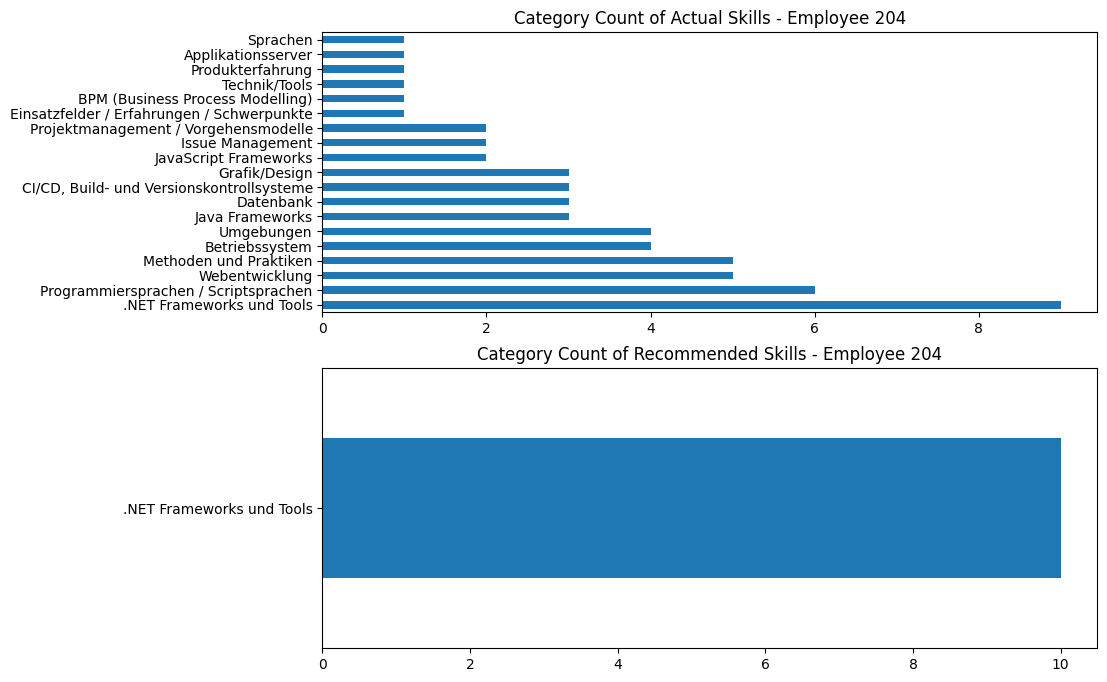

In [287]:
evaluate_employee_recoms(employee_dict[60])

Now, we want to implement a function, which will recommend skills for a new employee. The function should take in a user id and a dictionary of skills (maybe this can be handled a front end in implemenation in the future) and returns skill which are recommended for this user.

In [ ]:
new_id = 8774
new_skills = {
                "Windows 11":4,
                "Englisch":4,
                "Chinesisch (Mandarin)":2,
                "Python":4,
                "MATLAB":2,
                "Java":2,
                "MySQL":3,
                "SQLBase":3,
                "Microsoft SQL Server":3,
                "Google Cloud Platform":2,
                "MongoDB":1,
                "JSON":1,
                "Docker":2,
                "Statische Codeanalyse": 3,
                "Power BI":3,
                "Postman":2,
                "PowerShell":2,
                "Github actions":2,
            }

The long (not recommended) way: add new user by retraining whole model:

In [312]:
def get_recoms_for_new_employee(new_id,skilldict):

    all_ids = df_rated["Employee"].unique()
    all_skills = df_rated["Skill"].unique()

    if new_id in all_ids:
        return "Error: ID already taken. Please choose a different ID an try again."
    for skill in skilldict.keys():
        if skill not in all_skills:
            return "Skill " + skill + " not in database."
            # COMMENT: this is only a placeholder. For ideas on how to handle new skills, see "HOW TO HANDLE NEW SKILL" section 

    new_employee_df = pd.DataFrame()
    new_employee_df["Skill"] = skilldict.keys()
    new_employee_df["Rating"] = skilldict.values()
    new_employee_df["Employee"] = new_id
    new_employee_df = new_employee_df[["Employee","Skill","Rating"]]

    df_rated_new = pd.concat([df_rated,new_employee_df],ignore_index=True)
    # COMMENT: right now this function creates a new rated df. In order for this to retain newly added employees, it needs to overwrite the old df with the new data. 
    # this had to be implemented later on

    new_svd_data = Dataset.load_from_df(df_rated_new,reader)

    algo = gs.best_estimator["rmse"]
    #  COMMENT: right now the best model from the initial gridearch is taken. if the model is indeed to be retrained, it should be executing a new gridsearch and take the best estimator from this one
    trainset = new_svd_data.build_full_trainset()
    algo.fit(trainset)

    testset = trainset.build_anti_testset()
    predictions = algo.test(testset)

    return get_top_n(predictions, n=10)[new_id]

In [315]:
get_recoms_for_new_employee(new_id,new_skills)

[('Storefront', 3.8445459088103355),
 ('RFC', 3.823837126325091),
 ('SSO Anbindung', 3.8183883305095287),
 ('Design Thinking', 3.808222269493427),
 ('SAP ERP Anbindung', 3.7654212598164234),
 ('Security', 3.7569599361126116),
 ('Spartacus', 3.7266671530165993),
 ('Java FX', 3.720157746510981),
 ('SAP Commerce Cloud V2', 3.6864079314866705),
 ('User Tests', 3.6809605466867596)]

HOW TO HANDLE NEW SKILL: If a new user inserts a skill that is not already in the database, it has to be handled appropriately. Several things are to be considered: 
-  New skill could actually be one which already exists (typo or slightly different spelling) - e. g. "Pyhton", "SQL Server" etc. 
-  New skill could be out of scope of the recommender - e. g. Painting, Card tricks etc. 


On the other hand, the skill could actually be a sensual addition to the database, like for instance "R" which is not be found in the underlying data. This skill should then definitely be added. <br> <br>

How to handle this? Ideas: typos etc could be handled with similarity measures: if the new skill is very similar to existing ones, it yield an error, stating that the skill is too close to skill x
<br><br>
out of scope skills??? no idea. 

HOW TO HANDLE NEW USER: 
Right now, the model gets retrained every single time when a new user is added. This can't possibly be the way to go. On the other hand, never retraining bears the risk of the model getting inaccurate with increasing employees with different skillsets etc. 
-  Idea: for the first x employees, the recommender should not be retrained and just give recommendations for the new employee based on what they already know. 
-  After x employees, the model should be retrained on the whole data set, in order to minimized error. 

OPEN QUESTION: How can we add a single new employee to SVD++ and get recoms for the new instance? 

## Thoughts: Choice of Recommender System

The recommendation are purely based on the skillsets of other users. Therefore, a prerequisite of this approach to work is that the employees of a company have a somewhat "balanced" and representable skillset, which resemble the function they are in best. "Random" skills of employees (for example dataware manager who privately likes to develop mobile apps and is therefore proficient in JavaScript) will have an influence on the recommendations. Also the ratings, which are based on the frequency of the categories, which are associated with the respective skill have a big influence on the recommendations. It's not guaranteed though, that these ratings actually reflect the skill level of the specific employee and skill. <br> <br>

Question raised: Does it make sense to combine this matrix factorization approach, which solely takes other user's ratings into account with a content based approach, which takes information about the specific skills as well as stereotypical job profiles/project profiled (need skills for project) as in inputs? 

Would it make sense to combine a content based approach with the above demonstrated matrix facorization approach? <br>
What is needed for a content based approach to be implemented? Features for the skills: description of the skill, application fields  etc. <br>
Example for skill "Python": object oriented, dynamic, simplicity, back end, front ent, data science <br>
How to get this data? Web scraping, wikipedia API, data sources from neusta? <br> <br>

second thoughts - does it really make sense to recommend skills for an employee based on how similar these skills are to the already possessed ones? Would it be benefitial for a backend developer to learn the 6th programming language rather than a skill which would "round" up the employees skill portfolio in a better way or make this skill pallet more broad?

## WIP

- FIND OUT; HOW TO GET RECOMMENDATIONS FOR NEW EMPLOYEE WITHOUT RETRAINING THE WHOLE MODEL
- HANDLE NEW SKILLS ADDED
- GUI FOR NEW EMPLOYEE INSERTION? 
-  HANDLE RANDOM STATES: RIGHT NOW THE MODEL IS RECOMMENDING DIFFERENT THINGS EACH TIME IT IS USED
-  Decide if contend based recommender should be added